In [49]:
import pyspark

spark = pyspark.sql.SparkSession.builder.appName("MyApp") \
    .config("spark.driver.memory", "4g").getOrCreate()

# Load and create dataframe

In [50]:
from pyspark.sql.types import *

schema = StructType([
    StructField('duration', IntegerType(), True),
    StructField('protocol_type', StringType(), True),
    StructField('service', StringType(), True),
    StructField('flag', StringType(), True),
    StructField('src_bytes', IntegerType(), True),
    StructField('dst_bytes', IntegerType(), True),
    StructField('land', IntegerType(), True),
    StructField('wrong_fragment', IntegerType(), True),
    StructField('urgent', IntegerType(), True),
    StructField('hot', IntegerType(), True),
    StructField('num_failed_logins', IntegerType(), True),
    StructField('logged_in', IntegerType(), True),
    StructField('num_compromised', IntegerType(), True),
    StructField('root_shell', IntegerType(), True),
    StructField('su_attempted', IntegerType(), True),
    StructField('num_root', IntegerType(), True),
    StructField('num_file_creations', IntegerType(), True),
    StructField('num_shells', IntegerType(), True),
    StructField('num_access_files', IntegerType(), True),
    StructField('num_outbound_cmds', IntegerType(), True),
    StructField('is_host_login', IntegerType(), True),
    StructField('is_guest_login', IntegerType(), True),
    StructField('count', IntegerType(), True),
    StructField('srv_count', IntegerType(), True),
    StructField('serror_rate', FloatType(), True),
    StructField('srv_serror_rate', FloatType(), True),
    StructField('rerror_rate', FloatType(), True),
    StructField('srv_rerror_rate', FloatType(), True),
    StructField('same_srv_rate', FloatType(), True),
    StructField('diff_srv_rate', FloatType(), True),
    StructField('srv_diff_host_rate', FloatType(), True),
    StructField('dst_host_count', IntegerType(), True),
    StructField('dst_host_srv_count', IntegerType(), True),
    StructField('dst_host_same_srv_rate', FloatType(), True),
    StructField('dst_host_diff_srv_rate', FloatType(), True),
    StructField('dst_host_same_src_port_rate', FloatType(), True),
    StructField('dst_host_srv_diff_host_rate', FloatType(), True),
    StructField('dst_host_serror_rate', FloatType(), True),
    StructField('dst_host_srv_serror_rate', FloatType(), True),
    StructField('dst_host_rerror_rate', FloatType(), True),
    StructField('dst_host_srv_rerror_rate', FloatType(), True),
    StructField('label', StringType(), True)
])

kddcup_df = spark.read.csv("/data_serving/cleaned_kddcup.data.gz", sep = ',', header = True, schema = schema)
test_df = spark.read.csv("/data_serving/cleaned_test.data.gz", sep = ',', header = True, schema = schema)


### train

In [51]:
kddcup_df = kddcup_df.repartition(10)
kddcup_df.cache()
print("Number of partition: ", kddcup_df.rdd.getNumPartitions())

Number of partition:  1


### test

In [52]:
#test_df.cache()
print("Number of partition: ", test_df.rdd.getNumPartitions())

Number of partition:  1


In [5]:
kddcup_df

DataFrame[duration: int, protocol_type: string, service: string, flag: string, src_bytes: int, dst_bytes: int, land: int, wrong_fragment: int, urgent: int, hot: int, num_failed_logins: int, logged_in: int, num_compromised: int, root_shell: int, su_attempted: int, num_root: int, num_file_creations: int, num_shells: int, num_access_files: int, num_outbound_cmds: int, is_host_login: int, is_guest_login: int, count: int, srv_count: int, serror_rate: float, srv_serror_rate: float, rerror_rate: float, srv_rerror_rate: float, same_srv_rate: float, diff_srv_rate: float, srv_diff_host_rate: float, dst_host_count: int, dst_host_srv_count: int, dst_host_same_srv_rate: float, dst_host_diff_srv_rate: float, dst_host_same_src_port_rate: float, dst_host_srv_diff_host_rate: float, dst_host_serror_rate: float, dst_host_srv_serror_rate: float, dst_host_rerror_rate: float, dst_host_srv_rerror_rate: float, label: string]

In [6]:
test_df

DataFrame[duration: int, protocol_type: string, service: string, flag: string, src_bytes: int, dst_bytes: int, land: int, wrong_fragment: int, urgent: int, hot: int, num_failed_logins: int, logged_in: int, num_compromised: int, root_shell: int, su_attempted: int, num_root: int, num_file_creations: int, num_shells: int, num_access_files: int, num_outbound_cmds: int, is_host_login: int, is_guest_login: int, count: int, srv_count: int, serror_rate: float, srv_serror_rate: float, rerror_rate: float, srv_rerror_rate: float, same_srv_rate: float, diff_srv_rate: float, srv_diff_host_rate: float, dst_host_count: int, dst_host_srv_count: int, dst_host_same_srv_rate: float, dst_host_diff_srv_rate: float, dst_host_same_src_port_rate: float, dst_host_srv_diff_host_rate: float, dst_host_serror_rate: float, dst_host_srv_serror_rate: float, dst_host_rerror_rate: float, dst_host_srv_rerror_rate: float, label: string]

# Check duplicate rows before any manipulation

In [7]:
print(f"Number of duplicates in train dataset: {kddcup_df.count() - kddcup_df.distinct().count()}")
print(f"Number of duplicates in test dataset: {test_df.count() - test_df.distinct().count()}")

Number of duplicates in train dataset: 3823439
Number of duplicates in test dataset: 219031


### Remove duplicates

In [8]:
kddcup_distinct_df = kddcup_df.distinct()
kddcup_distinct_df.cache()
# Number of partitions after removing duplicate
print("Number of partitions after removing duplicate: ", kddcup_distinct_df.rdd.getNumPartitions())

Number of partitions after removing duplicate:  200


In [9]:
test_distinct_df = test_df.distinct()
test_distinct_df.cache()
# Number of partitions after removing duplicate
print("Number of partitions after removing duplicate: ", test_distinct_df.rdd.getNumPartitions())

Number of partitions after removing duplicate:  200


### Number of rows after removing duplicates

In [10]:
print("train: ", kddcup_distinct_df.count())
print("test: ", test_distinct_df.count())

train:  1074991
test:  73268


### reduce number of partitions

In [11]:
kddcup_distinct_df = kddcup_distinct_df.coalesce(10)
kddcup_distinct_df.cache()
print(kddcup_distinct_df.rdd.getNumPartitions())

test_distinct_df = test_distinct_df.coalesce(1)
test_distinct_df.cache()
print(test_distinct_df.rdd.getNumPartitions())

10
1


# Visulization

## Distinct values in each Categorical data

In [12]:
from pyspark.sql import Row

In [13]:
%%time
categorical_dict = {
    "protocol_type": kddcup_distinct_df.select("protocol_type").distinct().count(),
    "service": kddcup_distinct_df.select("service").distinct().count(),
    "flag": kddcup_distinct_df.select("flag").distinct().count(),
    "label": kddcup_distinct_df.select("label").distinct().count(),
}


categorical_data_df = spark.createDataFrame([Row(column=key, Distinc_values_count=value) for key, value in categorical_dict.items()]) 
categorical_data_df

CPU times: user 182 ms, sys: 37.1 ms, total: 219 ms
Wall time: 1.72 s


DataFrame[column: string, Distinc_values_count: bigint]

## Number of each label in dataset

### train

In [14]:
labels_count = kddcup_distinct_df.groupBy("label").count().orderBy("count", ascending=False)
labels_count.cache()
labels_count.show(23)

+---------------+------+
|          label| count|
+---------------+------+
|         normal|812813|
|        neptune|242149|
|          satan|  5019|
|        ipsweep|  3723|
|      portsweep|  3564|
|          smurf|  3007|
|           nmap|  1554|
|           back|   968|
|       teardrop|   918|
|    warezclient|   893|
|            pod|   206|
|   guess_passwd|    53|
|buffer_overflow|    30|
|    warezmaster|    20|
|           land|    19|
|           imap|    12|
|        rootkit|    10|
|     loadmodule|     9|
|      ftp_write|     8|
|       multihop|     7|
|            phf|     4|
|           perl|     3|
|            spy|     2|
+---------------+------+



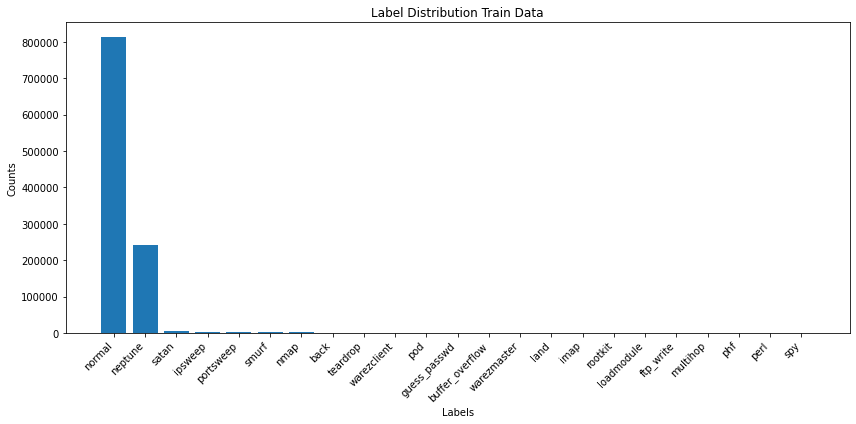

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

labels_count_pd = labels_count.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(labels_count_pd['label'], labels_count_pd['count'])
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution Train Data')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()


### test

In [16]:
labels_count_test = test_distinct_df.groupBy("label").count().orderBy("count", ascending=False)
labels_count_test.cache()
labels_count_test.show(23)

+---------------+-----+
|          label|count|
+---------------+-----+
|         normal|47912|
|        neptune|20332|
|   guess_passwd| 1302|
|    warezmaster| 1002|
|          smurf|  936|
|          satan|  860|
|           back|  386|
|      portsweep|  174|
|        ipsweep|  155|
|           nmap|   80|
|            pod|   45|
|buffer_overflow|   22|
|       multihop|   18|
|        rootkit|   13|
|       teardrop|   12|
|           land|    9|
|      ftp_write|    3|
|            phf|    2|
|           perl|    2|
|     loadmodule|    2|
|           imap|    1|
+---------------+-----+



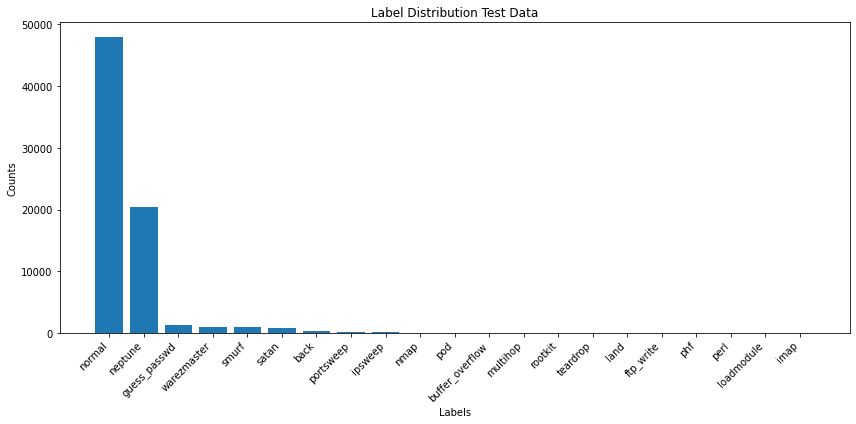

In [17]:
labels_count_pd = labels_count_test.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(labels_count_pd['label'], labels_count_pd['count'])
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution Test Data')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

# Spark MLlib
## Applying Random forest and Logistic Regression on dataset without resampling

## Random Forest Classifier

In [18]:
%%time

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler


labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel",  handleInvalid="skip")
protocol_typeIndexer = StringIndexer(inputCol="protocol_type", outputCol="indexedProtocol_type",  handleInvalid="skip")
serviceIndexer = StringIndexer(inputCol="service", outputCol="indexedService",  handleInvalid="skip")
flagIndexer = StringIndexer(inputCol="flag", outputCol="indexedFlag",  handleInvalid="skip")

featureAssembler = VectorAssembler(
    inputCols=[
        "duration",
        "indexedProtocol_type",
        "indexedService",
        "indexedFlag",
        "src_bytes",
        "dst_bytes",
        "land",
        "wrong_fragment",
        "urgent",
        "hot",
        "num_failed_logins",
        "logged_in",
        "num_compromised",
        "root_shell",
        "su_attempted",
        "num_root",
        "num_file_creations",
        "num_shells",
        "num_access_files",
        "num_outbound_cmds",
        "is_host_login",
        "is_guest_login",
        "count",
        "srv_count",
        "serror_rate",
        "srv_serror_rate",
        "rerror_rate",
        "srv_rerror_rate",
        "same_srv_rate",
        "diff_srv_rate",
        "srv_diff_host_rate",
        "dst_host_count",
        "dst_host_srv_count",
        "dst_host_same_srv_rate",
        "dst_host_diff_srv_rate",
        "dst_host_same_src_port_rate",
        "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate",
        "dst_host_srv_serror_rate",
        "dst_host_rerror_rate",
        "dst_host_srv_rerror_rate"
    ],
    outputCol="features"
)


# Train random forest classifier model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features", numTrees=10, maxBins=80)


# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, protocol_typeIndexer, serviceIndexer, flagIndexer, featureAssembler, rf])

# Train model.  This also runs the indexers.

model_ws_rf = pipeline.fit(kddcup_distinct_df)


# Make predictions.

predictions_ws_rf = model_ws_rf.transform(test_distinct_df)

CPU times: user 196 ms, sys: 220 ms, total: 415 ms
Wall time: 31.5 s


In [19]:
i2s = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=model_ws_rf.stages[0].labels)
predictions_ws_rf = i2s.transform(predictions_ws_rf)

In [20]:
rf = model_ws_rf.stages[-1]
# summary only
print(rf)

RandomForestClassificationModel: uid=RandomForestClassifier_4fb450e5f142, numTrees=10, numClasses=23, numFeatures=41


In [21]:
# Select example rows to display.
predictions_partial_ws_rf = predictions_ws_rf.select("label", "predictedLabel", "indexedLabel", "prediction")
predictions_partial_ws_rf.cache()

DataFrame[label: string, predictedLabel: string, indexedLabel: double, prediction: double]

### Evaluate result of Random Forest on dataset without resampling 

In [22]:
from pyspark.sql import functions as F

# count correct and errors
def evaluate_model_ws(pred_df):
    total = pred_df.count()
    corrects = pred_df.where(F.col("label") == F.col("predictedLabel"))
    errors =  pred_df.where(F.col("label") != F.col("predictedLabel"))

    TP = corrects.groupBy("label").count().withColumnRenamed("count", "TP")
    FN = errors.groupBy("label").count().withColumnRenamed("count", "FN")
    FP = errors.groupBy("predictedLabel").count().withColumnRenamed("count", "FP")

    
    result = pred_df.groupBy("label").count().withColumnRenamed("count", "total")
    
    # join
    result = result.join(TP, on="label", how="left").select(result.label, TP.TP)
    result = result.join(FN, on="label", how="left").select(result.label, result.TP, FN.FN)
    result = result.join(FP, on=FP.predictedLabel == result.label, how="left").select(result.label, result.TP, result.FN, FP.FP)
    
    # Fill null values for rows where either error or correct is 0
    result = result.na.fill(0, subset=["TP", "FN", "FP"])
    
    result = result.withColumn("TN", total-result.TP-result.FN-result.FP)
    
    result = result.withColumn("precision", result.TP/(result.TP+result.FP))
    result = result.withColumn("recall", result.TP/(result.TP+result.FN))
    result = result.withColumn("f1", 2*(result.precision*result.recall)/(result.precision+result.recall))
    result = result.na.fill(0, subset=["precision", "recall", "f1"])
    
    result = result.withColumn("precision%", F.concat((F.floor(result.precision*1000)/10).cast(StringType()), F.lit("%")))
    result = result.withColumn("recall%", F.concat((F.floor(result.recall*1000)/10).cast(StringType()), F.lit("%")))
    result = result.withColumn("f1%", F.concat((F.floor(result.f1*1000)/10).cast(StringType()), F.lit("%")))
    
    result = result.select("label", "TP", "FN", "FP", "TN", "precision%", "recall%", "f1%")

    # Order by total predictions
    result = result.orderBy(result.TP, ascending=False)

    result.show(23)

In [23]:
evaluate_model_ws(predictions_partial_ws_rf)
print("Random Forest on dataset without resampling")

+---------------+-----+----+----+-----+----------+-------+------+
|          label|   TP|  FN|  FP|   TN|precision%|recall%|   f1%|
+---------------+-----+----+----+-----+----------+-------+------+
|         normal|47783| 127|3175|22181|     93.7%|  99.7%| 96.6%|
|        neptune|19703| 629|  36|52898|     99.8%|  96.9%| 98.3%|
|          smurf|  857|  79|   1|72329|     99.8%|  91.5%| 95.5%|
|          satan|  658| 202| 629|71777|     51.1%|  76.5%| 61.2%|
|        ipsweep|  149|   6|  27|73084|     84.6%|  96.1%| 90.0%|
|      portsweep|  127|  47|  39|73053|     76.5%|  72.9%| 74.7%|
|           nmap|   80|   0|   0|73186|    100.0%| 100.0%|100.0%|
|            pod|    2|  43|   0|73221|    100.0%|   4.4%|  8.5%|
|   guess_passwd|    0|1302|   0|71964|      0.0%|   0.0%|  0.0%|
|    warezmaster|    0|1002|   0|72264|      0.0%|   0.0%|  0.0%|
|        rootkit|    0|  13|   0|73253|      0.0%|   0.0%|  0.0%|
|           back|    0| 386|   0|72880|      0.0%|   0.0%|  0.0%|
|       mu

In [24]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions_partial_ws_rf)
print(f"F1 score: {f1_score}")

F1 score: 0.9292064440821634


## Logistic Regression

In [25]:
%%time

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler

labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel",  handleInvalid="skip")
protocol_typeIndexer = StringIndexer(inputCol="protocol_type", outputCol="indexedProtocol_type",  handleInvalid="skip")
serviceIndexer = StringIndexer(inputCol="service", outputCol="indexedService",  handleInvalid="skip")
flagIndexer = StringIndexer(inputCol="flag", outputCol="indexedFlag",  handleInvalid="skip")

featureAssembler = VectorAssembler(
    inputCols=[
        "duration",
        "indexedProtocol_type",
        "indexedService",
        "indexedFlag",
        "src_bytes",
        "dst_bytes",
        "land",
        "wrong_fragment",
        "urgent",
        "hot",
        "num_failed_logins",
        "logged_in",
        "num_compromised",
        "root_shell",
        "su_attempted",
        "num_root",
        "num_file_creations",
        "num_shells",
        "num_access_files",
        "num_outbound_cmds",
        "is_host_login",
        "is_guest_login",
        "count",
        "srv_count",
        "serror_rate",
        "srv_serror_rate",
        "rerror_rate",
        "srv_rerror_rate",
        "same_srv_rate",
        "diff_srv_rate",
        "srv_diff_host_rate",
        "dst_host_count",
        "dst_host_srv_count",
        "dst_host_same_srv_rate",
        "dst_host_diff_srv_rate",
        "dst_host_same_src_port_rate",
        "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate",
        "dst_host_srv_serror_rate",
        "dst_host_rerror_rate",
        "dst_host_srv_rerror_rate"
    ],
    outputCol="features"
)


# Train a Logistic Regression model.
lr = LogisticRegression(labelCol="indexedLabel", featuresCol="features")

# Chain indexers and model in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, protocol_typeIndexer, serviceIndexer, flagIndexer, featureAssembler, lr])

# Train model.  This also runs the indexers.
model_ws_lr = pipeline.fit(kddcup_distinct_df)

# Make predictions.
predictions_ws_lr = model_ws_lr.transform(test_distinct_df)

CPU times: user 117 ms, sys: 66.9 ms, total: 184 ms
Wall time: 4min 9s


In [26]:
lr = model_ws_lr.stages[-1]
# summary only
print(lr)

LogisticRegressionModel: uid=LogisticRegression_78bbd6e03027, numClasses=23, numFeatures=41


In [27]:
i2s = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=model_ws_lr.stages[0].labels)
predictions_ws_lr = i2s.transform(predictions_ws_lr)

In [28]:
# Select example rows to display.
predictions_partial_ws_lr = predictions_ws_lr.select("label", "indexedLabel", "predictedLabel", "prediction")
predictions_partial_ws_lr.cache()

DataFrame[label: string, indexedLabel: double, predictedLabel: string, prediction: double]

### Evaluate result of Logistic Regression on dataset without resampling 

In [29]:
# Logistic Regression on dataset without resampling
evaluate_model_ws(predictions_partial_ws_lr)

+---------------+-----+----+----+-----+----------+-------+-----+
|          label|   TP|  FN|  FP|   TN|precision%|recall%|  f1%|
+---------------+-----+----+----+-----+----------+-------+-----+
|         normal|47271| 639|2592|22764|     94.8%|  98.6%|96.6%|
|        neptune|20319|  13|   0|52934|    100.0%|  99.9%|99.9%|
|          smurf|  926|  10| 372|71958|     71.3%|  98.9%|82.9%|
|          satan|  836|  24| 161|72245|     83.8%|  97.2%|90.0%|
|           back|  202| 184|   5|72875|     97.5%|  52.3%|68.1%|
|      portsweep|  162|  12|  39|73053|     80.5%|  93.1%|86.4%|
|        ipsweep|  149|   6|   5|73106|     96.7%|  96.1%|96.4%|
|           nmap|   78|   2|   3|73183|     96.2%|  97.5%|96.8%|
|            pod|   40|   5|  15|73206|     72.7%|  88.8%|79.9%|
|       teardrop|   12|   0|  37|73217|     24.4%| 100.0%|39.3%|
|           land|    8|   1|   0|73257|    100.0%|  88.8%|94.1%|
|   guess_passwd|    1|1301|   2|71962|     33.3%|   0.0%| 0.1%|
|            phf|    1|  

In [30]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions_partial_ws_lr)
print(f"F1 score: {f1_score}")

F1 score: 0.9403511913869789


# OverSampling minor labels

### define function for oversampling

In [31]:
# number of neptune labels can be considered as target_number
def oversampling(df, label, target_number=5000):
    minor_df = df.filter(col("label") == label)
    ratio = target_number / minor_df.count()
    if ratio <= 1:
        return minor_df
    oversampled_df = minor_df.sample(withReplacement=True, fraction=ratio)
    return oversampled_df

In [32]:
# take minor labels in a list
labels_exclude_firstTwo = [row["label"] for row in kddcup_distinct_df.groupBy("label").count().orderBy("count", ascending=True).collect()]

### Create a new dataframe where we join all labels together after oversampling

In [33]:
from pyspark.sql.functions import col
oversampled_df = spark.createDataFrame([], kddcup_df.schema)

for label in labels_exclude_firstTwo:
    oversampled_label_df = oversampling(kddcup_distinct_df, label)
    oversampled_df = oversampled_df.union(oversampled_label_df)

In [34]:
oversampled_df = oversampled_df.coalesce(10)
oversampled_df.cache()
# Take number of partitions after oversampling. It increased by spark to 212
print(oversampled_df.rdd.getNumPartitions())

10


In [35]:
# Number of rows after oversampling
oversampled_df.count()

1160265

In [36]:
# count number of minor labels after oversampling
oversampled_df.groupBy("label").count().orderBy("count", ascending=False).show(23)

+---------------+------+
|          label| count|
+---------------+------+
|         normal|812813|
|        neptune|242149|
|       multihop|  5139|
|           back|  5114|
|           land|  5073|
|    warezmaster|  5069|
|           perl|  5039|
|   guess_passwd|  5037|
|       teardrop|  5037|
|           imap|  5034|
|      ftp_write|  5030|
|      portsweep|  5023|
|            spy|  5021|
|          satan|  5019|
|          smurf|  5019|
|           nmap|  5010|
|buffer_overflow|  4997|
|            pod|  4986|
|        ipsweep|  4970|
|     loadmodule|  4967|
|        rootkit|  4940|
|            phf|  4899|
|    warezclient|  4880|
+---------------+------+



In [37]:
# Ensure oversampling used all different rows of each label. 
# For example, we have only two rows with label 'spy' in original dataset. 
# Oversampling has to include these two rows as original dataset.
oversampled_df.distinct().groupBy("label").count()

DataFrame[label: string, count: bigint]

### Visulize dataset after sampling

In [38]:
sampled_labels_count = oversampled_df.groupBy("label").count().orderBy("count", ascending=False)
sampled_labels_count.cache()
sampled_labels_count.show(23)

+---------------+------+
|          label| count|
+---------------+------+
|         normal|812813|
|        neptune|242149|
|       multihop|  5139|
|           back|  5114|
|           land|  5073|
|    warezmaster|  5069|
|           perl|  5039|
|   guess_passwd|  5037|
|       teardrop|  5037|
|           imap|  5034|
|      ftp_write|  5030|
|      portsweep|  5023|
|            spy|  5021|
|          satan|  5019|
|          smurf|  5019|
|           nmap|  5010|
|buffer_overflow|  4997|
|            pod|  4986|
|        ipsweep|  4970|
|     loadmodule|  4967|
|        rootkit|  4940|
|            phf|  4899|
|    warezclient|  4880|
+---------------+------+



In [39]:
# Distinct values for each label
oversampled_df.distinct().groupBy("label").count().show(23)

+---------------+------+
|          label| count|
+---------------+------+
|          satan|  5019|
|        neptune|242149|
|           nmap|  1503|
|      portsweep|  2682|
|           back|   960|
|    warezclient|   892|
|   guess_passwd|    53|
|         normal|812813|
|        rootkit|    10|
|           perl|     3|
|buffer_overflow|    30|
|       multihop|     7|
|        ipsweep|  2747|
|    warezmaster|    20|
|           imap|    12|
|       teardrop|   913|
|           land|    19|
|            pod|   206|
|      ftp_write|     8|
|          smurf|  2445|
|     loadmodule|     9|
|            phf|     4|
|            spy|     2|
+---------------+------+



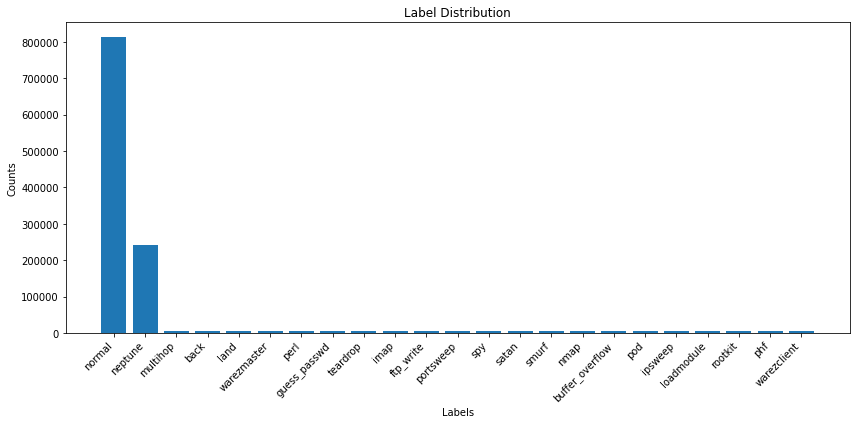

In [40]:
sampled_labels_count_pd = sampled_labels_count.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(sampled_labels_count_pd['label'], sampled_labels_count_pd['count'])
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

## Logistic Regression on dataset with resampling

## Logistic Regression

In [41]:
%%time

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler

labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel",  handleInvalid="skip")
protocol_typeIndexer = StringIndexer(inputCol="protocol_type", outputCol="indexedProtocol_type",  handleInvalid="skip")
serviceIndexer = StringIndexer(inputCol="service", outputCol="indexedService",  handleInvalid="skip")
flagIndexer = StringIndexer(inputCol="flag", outputCol="indexedFlag",  handleInvalid="skip")

featureAssembler = VectorAssembler(
    inputCols=[
        "duration",
        "indexedProtocol_type",
        "indexedService",
        "indexedFlag",
        "src_bytes",
        "dst_bytes",
        "land",
        "wrong_fragment",
        "urgent",
        "hot",
        "num_failed_logins",
        "logged_in",
        "num_compromised",
        "root_shell",
        "su_attempted",
        "num_root",
        "num_file_creations",
        "num_shells",
        "num_access_files",
        "num_outbound_cmds",
        "is_host_login",
        "is_guest_login",
        "count",
        "srv_count",
        "serror_rate",
        "srv_serror_rate",
        "rerror_rate",
        "srv_rerror_rate",
        "same_srv_rate",
        "diff_srv_rate",
        "srv_diff_host_rate",
        "dst_host_count",
        "dst_host_srv_count",
        "dst_host_same_srv_rate",
        "dst_host_diff_srv_rate",
        "dst_host_same_src_port_rate",
        "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate",
        "dst_host_srv_serror_rate",
        "dst_host_rerror_rate",
        "dst_host_srv_rerror_rate"
    ],
    outputCol="features"
)


# Train a Logistic Regression model.
lr = LogisticRegression(labelCol="indexedLabel", featuresCol="features")

# Chain indexers and model in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, protocol_typeIndexer, serviceIndexer, flagIndexer, featureAssembler, lr])

# Train model.  This also runs the indexers.
model_s_lr = pipeline.fit(oversampled_df)

# Make predictions.
predictions_s_lr = model_s_lr.transform(test_distinct_df)

CPU times: user 303 ms, sys: 81.5 ms, total: 384 ms
Wall time: 4min 48s


In [42]:
lr = model_s_lr.stages[-1]
# summary only
print(lr)

LogisticRegressionModel: uid=LogisticRegression_34cb0af815e4, numClasses=23, numFeatures=41


In [43]:
i2s = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=model_s_lr.stages[0].labels)
predictions_s_lr = i2s.transform(predictions_s_lr)

In [44]:
# Select example rows to display.
predictions_partial_s_lr = predictions_s_lr.select("label", "indexedLabel", "predictedLabel", "prediction")


In [45]:
print(predictions_partial_s_lr.rdd.getNumPartitions())
predictions_partial_s_lr.cache()

1


DataFrame[label: string, indexedLabel: double, predictedLabel: string, prediction: double]

In [46]:
predictions_partial_s_lr.count()

73266

In [47]:
# Logistic Regression on dataset with resampling
evaluate_model_ws(predictions_partial_s_lr)

+---------------+-----+----+----+-----+----------+-------+------+
|          label|   TP|  FN|  FP|   TN|precision%|recall%|   f1%|
+---------------+-----+----+----+-----+----------+-------+------+
|         normal|47134| 776|1985|23371|     95.9%|  98.3%| 97.1%|
|        neptune|20286|  46|   0|52934|    100.0%|  99.7%| 99.8%|
|          smurf|  932|   4| 389|71941|     70.5%|  99.5%| 82.5%|
|          satan|  831|  29| 198|72208|     80.7%|  96.6%| 87.9%|
|           back|  231| 155|   8|72872|     96.6%|  59.8%| 73.9%|
|      portsweep|  164|  10|  47|73045|     77.7%|  94.2%| 85.1%|
|        ipsweep|  149|   6|   8|73103|     94.9%|  96.1%| 95.5%|
|   guess_passwd|   93|1209|   2|71962|     97.8%|   7.1%| 13.3%|
|           nmap|   78|   2|  30|73156|     72.2%|  97.5%| 82.9%|
|            pod|   43|   2|  17|73204|     71.6%|  95.5%| 81.9%|
|    warezmaster|   10| 992|   0|72264|    100.0%|   0.9%|  1.9%|
|       teardrop|   10|   2|  37|73217|     21.2%|  83.3%| 33.8%|
|         

In [48]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions_partial_s_lr)
print(f"F1 score: {f1_score}")


F1 score: 0.9456493634394468
